# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [2]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [3]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [4]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [5]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.889539375174884


In [6]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [7]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [8]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [9]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 588.4599999999997
random: 294.37999999999994


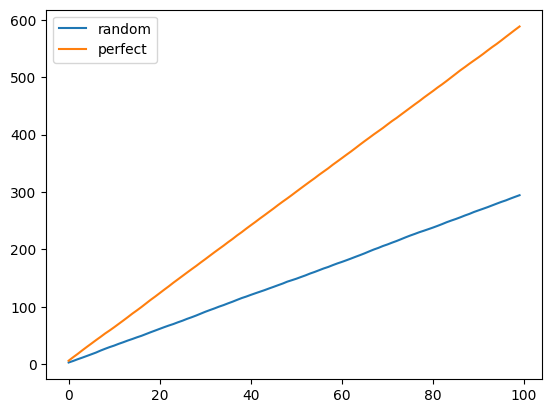

In [10]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.92
random: 2.88


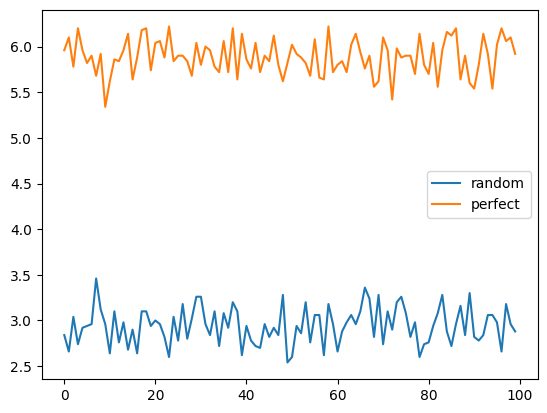

In [11]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [12]:
import random

class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon
        
        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        # raise NotImplementedError()
        sorted_arms = sorted(self.arm_ids, key=lambda arm_id: self.ctr[arm_id])
        random_arms = self.arm_ids.copy() 
        random.shuffle(self.arm_ids)
        recommendations = []

        for arm1, arm2 in zip(sorted_arms, random_arms):
            if random.random() > self.epsilon:
                recommendations.append(arm1)
            else:
                recommendations.append(arm2)
        
        return list(set(recommendations))[:size]
        

    def feedback(self, arm_id, payout):
        # raise NotImplementedError()
        self.impressions[arm_id] += 1
        if payout > 0:
            self.clicks[arm_id] += 1
            self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

In [13]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = 0
    
    def recommend(self, size):
        # raise NotImplementedError()
        return sorted(self.arm_ids, key = lambda arm_id: self.ctr[arm_id] + self._optimism(arm_id), reverse=True)[:size]
    
    def feedback(self, arm_id, payout):
        # raise NotImplementedError()
        self.impressions[arm_id] += 1
        if payout > 0:
            self.clicks[arm_id] += 1
            self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]
        
    def _optimism(self, arm_id):
        # raise NotImplementedError()
        return sqrt(2 * log(sum(self.impressions.values()) / self.impressions[arm_id])) if self.impressions[arm_id] > 0 else 0

In [14]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        # raise NotImplementedError()
        return sorted(self.arm_ids, key=lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]), reverse=True)[:size]
    
    def feedback(self, arm_id, payout):
        # raise NotImplementedError()
        if payout > 0:
            self.a[arm_id] += 1
        else:
            self.b[arm_id] += 1
    

## Część 3. - zgrubne porównanie bandytów

In [15]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
# bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
#                 for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [16]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_10_10: 6.14
ts_10_5: 6.04
ts_10_50: 5.9
ts_20_20: 5.9
ts_1_5: 5.82
ts_5_5: 5.8
ts_50_20: 5.78
ts_10_20: 5.74
ts_1_10: 5.72
ts_50_1: 5.72
ts_20_1: 5.7
ts_20_50: 5.7
ts_50_5: 5.7
ts_5_50: 5.68
ts_50_10: 5.68
ts_1_1: 5.66
perfect: 5.6
ts_5_1: 5.6
ts_10_1: 5.6
ts_1_50: 5.58
ts_20_5: 5.56
ts_5_20: 5.54
ts_5_10: 5.5
ts_1_20: 5.46
ts_50_50: 5.46
ts_20_10: 5.44
random: 3.02
egreedy_0.1: 2.56
egreedy_0.01: 2.5
ucb_0.01: 2.46
egreedy_0.05: 2.38
egreedy_0.25: 2.38
ucb_10: 2.38
ucb_0.1: 2.3
ucb_1: 2.28


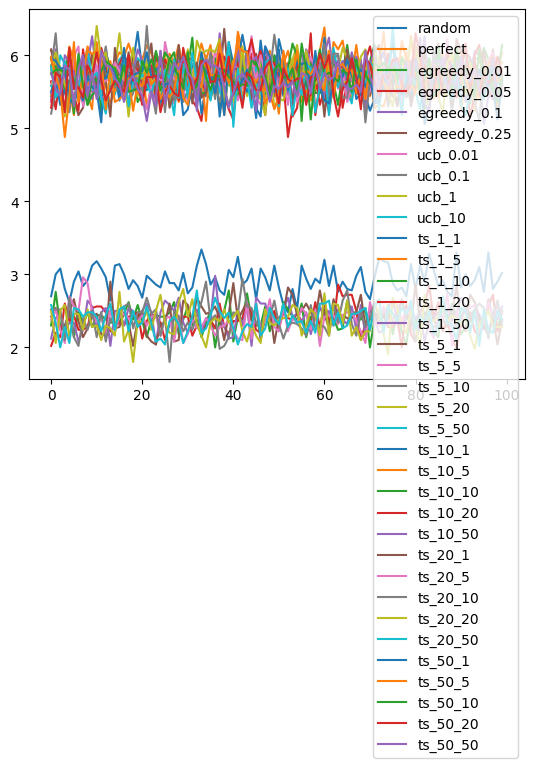

In [17]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 587.64
ts_10_10: 574.5600000000004
ts_20_20: 574.0400000000001
ts_10_50: 573.76
ts_1_1: 573.5399999999998
ts_5_20: 573.0799999999999
ts_20_1: 572.5799999999998
ts_1_50: 572.56
ts_50_10: 572.1600000000002
ts_10_20: 570.7399999999998
ts_5_1: 569.8000000000002
ts_50_5: 569.4
ts_10_5: 569.3799999999998
ts_1_10: 568.9800000000001
ts_1_5: 568.9399999999999
ts_20_5: 568.4200000000001
ts_5_5: 567.7799999999999
ts_5_50: 567.7399999999999
ts_20_10: 567.4800000000001
ts_50_20: 567.3799999999998
ts_50_1: 566.98
ts_5_10: 566.88
ts_50_50: 566.0200000000003
ts_10_1: 564.7199999999995
ts_20_50: 564.4600000000002
ts_1_20: 563.9800000000002
random: 292.52
egreedy_0.25: 242.64
egreedy_0.1: 240.96000000000004
egreedy_0.01: 238.85999999999993
ucb_0.1: 238.64000000000004
ucb_0.01: 237.88000000000008
ucb_10: 237.72
egreedy_0.05: 237.10000000000002
ucb_1: 235.16000000000005


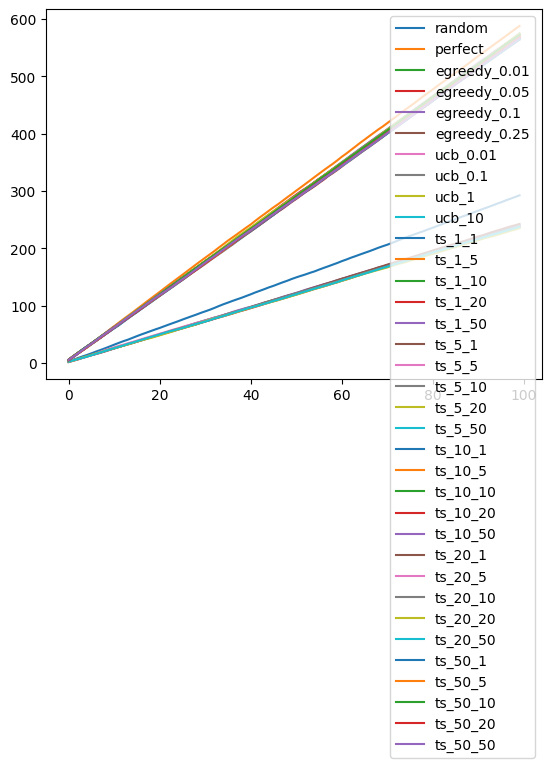

In [18]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [ ]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [ ]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    raise NotImplementedError()

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    raise NotImplementedError()

In [ ]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

In [ ]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    return tabulate(data, headers, tablefmt='github')

In [ ]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = ...
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

raise NotImplementedError()

print_test_results(results)